# NSB with contours

This notebook contains the essentials to plot the night sky brighntess from an image.
The beginning of this notenook will contain the essential libraries an input data needed.
The aim is to clearly show how to do it and avoid exploratory code.

## Python libraries

In [1]:
# -------------------------
# Standard Python libraries
# -------------------------

import os
from enum import Enum
from fractions import Fraction

# ---------------------
# Third party libraries
# ---------------------
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap

import exifread
import numpy as np
import numpy.ma as ma
import astropy.units as u
from astropy.io import fits
from astropy.convolution import convolve, convolve_fft, Gaussian2DKernel

from astropy.table import Table
from scipy.ndimage import gaussian_filter, median_filter, uniform_filter

## Auxiliar functions

In [2]:
class Magnitude(float, Enum):
    SUPER_BRIGHT = 8.0
    BRIGHT = 10
    MODERATE = 17
    MEDIUM_DARK = 18.6
    DARK = 21.0
    SUPER_DARK = 22.0
    BLACK = 24.0
    
def nixnox_colormap(split_level: int =192) -> LinearSegmentedColormap:
    """make a 256 point combined colormap from reversed viridis and YlOrRd"""
    assert 0 < split_level < 256
    colors2 = plt.cm.viridis_r(np.linspace(0, 1, split_level))
    colors1 = plt.cm.YlOrRd_r(np.linspace(0, 1, 256 - split_level))
    colors = np.vstack((colors1, colors2))
    return mcolors.LinearSegmentedColormap.from_list("nixnos_cmap", colors)

# esta version no la estoy usando, la tengo como codigo de referencia
def levels(nsb_map, min_mag: float, max_mag: float, threshold_mag: float, dark_mag: float= Magnitude.MEDIUM_DARK,):
    m_step_1 = 0.2
    m_step_2 = 0.4
    nticks = 12
    if np.max(nsb_map) > dark_mag:  
        dark_nsb_levels = np.arange(threshold_mag, max_mag + m_step_1 + 0.1, m_step_1)
        # more width between contour line for lower magnitudes
        bright_nsb_levels = np.arange(min_mag, threshold_mag, m_step_2)
        all_nsb_levels = np.arange(min_mag, max_mag + m_step_1 + 0.1, m_step_2)
    else:
        all_nsb_levels = np.arange(min_mag, max_mag, m_step_1)  # visible contour lines
        dark_nsb_levels = None
        bright_nsb_levels = None
    print(f"ALL = {all_nsb_levels}")
    print(f"DARK = {dark_nsb_levels}")
    print(f"BRIGHT = {bright_nsb_levels}")
    return all_nsb_levels, dark_nsb_levels, bright_nsb_levels

# MI VERSION SIMPLIFICADA
def levels(nsb_map, min_mag: float, max_mag: float, threshold_mag: float):
    """Returns 3 contour levels: full, bright and dark"""
    m_step_1 = 0.2
    m_step_2 = 2 * m_step_1
    all_nsb_levels = np.arange(min_mag, max_mag + m_step_2, m_step_2)
    if np.max(nsb_map) > threshold_mag:  
        dark_nsb_levels = np.arange(threshold_mag, max_mag + m_step_1, m_step_1)
        # more width between contour line for lower magnitudes
        bright_nsb_levels = np.arange(min_mag, threshold_mag, m_step_2)
    else:
        dark_nsb_levels = None
        bright_nsb_levels = None
    print(f"ALL = {all_nsb_levels}")
    print(f"DARK = {dark_nsb_levels}")
    print(f"BRIGHT = {bright_nsb_levels}")
    return all_nsb_levels, dark_nsb_levels, bright_nsb_levels

def plot_magnitudes(nsb_map, cmap, min_mag, max_mag, xmin=450, xmax=2650, fsize=14):
    fig, ax = plt.subplots(ncols=1,figsize=(8,6),dpi=150)
    im = ax.imshow(nsb_map,cmap=cmap, vmin=min_mag, vmax=max_mag)
    ax.set_xlabel('u [pixel]',fontdict={'size':fsize})
    ax.set_ylabel('v [pixel]',fontdict={'size':fsize})
    cbar = fig.colorbar(im, shrink=0.99, ax=ax)
    cbar.set_label('G Brightness [mag/arcsec$^2$]',fontdict={'size':fsize}) 
    cbar.ax.tick_params(labelsize=14)
    plt.xticks(size=fsize)
    plt.yticks(size=fsize)
    plt.xlim(xmin,xmax)

def plot_contours(nsb_map, cmap, min_mag, max_mag, xmin=450, xmax=2650, fsize=14):
    fig, ax = plt.subplots(ncols=1,figsize=(8,6),dpi=150)
    all_nsb_levels, dark_nsb_levels, bright_nsb_levels = levels(nsb_map, min_mag, max_mag, threshold_mag= Magnitude.MEDIUM_DARK)
    #im = ax.imshow(NSB_filt,cmap=nixnox, vmin=20, vmax=22)
    ax.set_xlabel('u [pixel]',fontdict={'size':fsize})
    ax.set_ylabel('v [pixel]',fontdict={'size':fsize})
    cax = ax.contourf(nsb_map,
                cmap=cmap,
                vmin=min_mag,
                vmax=max_mag,
                levels=all_nsb_levels,
                origin="image",
    )
    if dark_nsb_levels is not None:
        cax_lines = ax.contour(cax, colors="k", levels=bright_nsb_levels, linewidths=1)
        ax.clabel(cax_lines,colors="k",inline=True,fmt="%1.1f",rightside_up=True,fontsize="medium")
        cax_lines = ax.contour(cax, colors="y", levels=dark_nsb_levels, linewidths=1)
        ax.clabel(cax_lines,colors="y",inline=True,fmt="%1.1f",rightside_up=True,fontsize="medium")
       
    # extra contour lines over 22 mag/arcsec2
    # todo esto no lo estoy usando de momento
    if False:
        m_step_2 = 0.4
        high_levels = np.arange(Magnitude.SUPER_DARK, Magnitude.BLACK, m_step_2)
        cax_lines = ax.contour(cax, colors="k", levels=high_levels, linewidths=1)
        ax.clabel(
            cax_lines,
            colors="k",
            inline=True,
            fmt="%1.1f",
            rightside_up=True,
            fontsize="medium",
        )
        # extra contour lines below 17 mag/arcsec2
        low_levels = np.arange(Magnitude.SUPER_BRIGHT, Magnitude.MODERATE, 1)
        cax_lines = ax.contour(cax, colors="k", levels=low_levels, linewidths=0.5)
        ax.clabel(
            cax_lines,
            colors="k",
            inline=True,
            fmt="%1.1f",
            rightside_up=True,
            fontsize="small",
        )
    cb_ticks = np.round(np.linspace(min_mag, max_mag, num=12, endpoint=True), 1)
    cb = fig.colorbar(cax, orientation="vertical", shrink=0.99, ticks=cb_ticks, pad=0.08)
    cb.set_label("Sky Brightness [mag/arcsec$^2$]", fontsize=fsize)
    cb.ax.tick_params(labelsize=fsize)
    plt.xticks(size=fsize)
    plt.yticks(size=fsize)
    plt.xlim(450,2650)

def plot_contours(nsb_map, filtered_nsb_map, cmap, min_mag, max_mag, xmin=450, xmax=2650, fsize=14):
    fig, ax = plt.subplots(ncols=1,figsize=(8,6),dpi=150)
    all_nsb_levels, dark_nsb_levels, bright_nsb_levels = levels(nsb_map, min_mag, max_mag, threshold_mag= Magnitude.MEDIUM_DARK)
    im = ax.imshow(nsb_map,cmap=nixnox, vmin=20, vmax=22)
    ax.set_xlabel('u [pixel]',fontdict={'size':fsize})
    ax.set_ylabel('v [pixel]',fontdict={'size':fsize})
    cax = ax.contour(filtered_nsb_map,
                cmap=cmap,
                vmin=min_mag,
                vmax=max_mag,
                levels=all_nsb_levels,
                #colors="y",
                inline=True,
                fmt="%1.1f",
                rightside_up=True,
                fontsize="medium"
    )
    cb_ticks = np.round(np.linspace(min_mag, max_mag, num=12, endpoint=True), 1)
    cb = fig.colorbar(cax, orientation="vertical", shrink=0.99, ticks=cb_ticks, pad=0.08)
    cb.set_label("Sky Brightness [mag/arcsec$^2$]", fontsize=fsize)
    cb.ax.tick_params(labelsize=fsize)
    plt.xticks(size=fsize)
    plt.yticks(size=fsize)
    plt.xlim(450,2650)
       

## Input data and constants

### Input Path
The sample image - made by Rémi Boucher - was located in Pic du Midi Observatory (France). 
This is a RAW format image.

In [3]:
SAMPLE_IMAGE = 'IMG_9467.CR2'
ipath   = os.path.join(os.getcwd(), "images", "remi")
ifile = os.path.join(ipath, SAMPLE_IMAGE) 

### Escale factor area in pixels to area in arcsec2
For the current image, the plate are scale in ${arsec}^2$ is

In [4]:
DOMEGA = 57758.36824261549

### Zero points

From the photometry notebook, we have determined the following photemtry zero points per channel

In [5]:
ZP_B = 10.93
ZP_G = 11.11
ZP_R = 10.0

### Exposure time
We obtaion the exposure time in seconds from the EXIF metadata in the original image

In [6]:
with open(ifile, 'rb') as f:
    exif_tags = exifread.process_file(f)
T_EXPO = float(Fraction(str(exif_tags.get('EXIF ExposureTime'))))

### Input Pixels
We already have the `IMG_9467_G2_corr.fits` vigneting corrected FITS file

In [7]:
filename = ifile.replace('.CR2','_G2_corr.fits')
G2_PIX  = fits.getdata(filename)
G2_PIX = ma.masked_array(G2_PIX, mask=[G2_PIX == 0])

### Night Sky Brightness map
Since we have the exposure time `T_EXPO`, the pixel values in DN `G2_PIX`, the zero point corresponding to the desired channel `ZP_G` and the pixel area scale `DOMEGA`, we can transfrom the image from its brighnets value in DN to a magnitude scale in $mag/{arcsec}²$ 

The quirk here resides in the corrected image, whose pixels out of the fisheye lens have been set to zero. This poses a problem when computing magnitudes. The solution is to use a masked array and perform a masked ${log}_{10}$ function.

In [8]:
NSB = ZP_G - 2.5*np.ma.log10(G2_PIX/(DOMEGA*T_EXPO))

## Plotting the Night Sky Brightness map

We first display the Night Sky Brightness map as is, after magnitude transformation

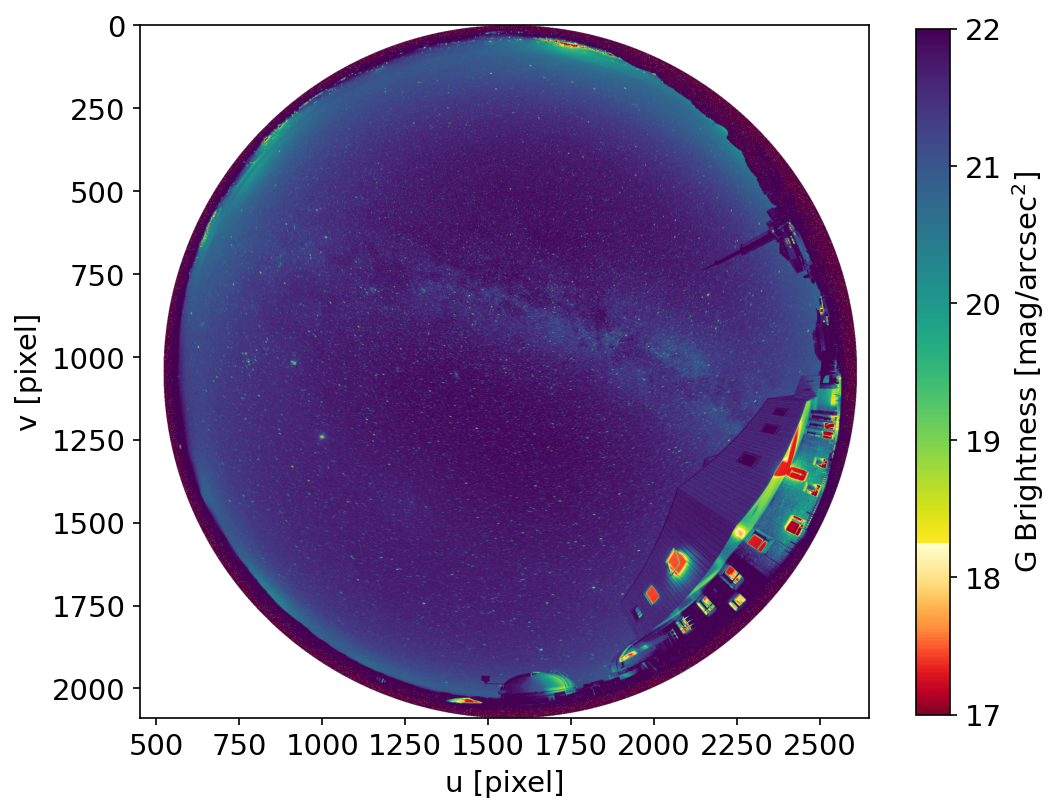

In [9]:
nixnox = nixnox_colormap()
plot_magnitudes(NSB, cmap=nixnox, min_mag=Magnitude.MODERATE, max_mag=Magnitude.SUPER_DARK,)

To plot contour lines, we must first perform a heavy low pass filtering on the magnitudes map. The plot below show the NSB map after filtering.

**HE PUESTO LAS LINEAS DE CONTORNO EN AMARILLO PARA DISTINGUIRLAS DEL COLOR BLANCO QUE SALE EN EL MAPA DE CONTORNO, ME IMAGINO QUE POR DATOS INVALIDOS.**

In [10]:
kernel = Gaussian2DKernel(15)
NSB_filt = convolve_fft(NSB, kernel,  boundary="fill", fill_value=0, nan_treatment="fill", preserve_nan=False)
#plot_magnitudes(NSB_filt,nixnox,min_mag=Magnitude.MODERATE, max_mag=Magnitude.SUPER_DARK,)

ALL = [17.  17.4 17.8 18.2 18.6 19.  19.4 19.8 20.2 20.6 21.  21.4 21.8 22.2]
DARK = [18.6 18.8 19.  19.2 19.4 19.6 19.8 20.  20.2 20.4 20.6 20.8 21.  21.2
 21.4 21.6 21.8 22. ]
BRIGHT = [17.  17.4 17.8 18.2 18.6]


/tmp/ipykernel_19139/3831356543.py:125: UserWarning: The following kwargs were not used by contour: 'inline', 'fmt', 'rightside_up', 'fontsize'
  cax = ax.contour(filtered_nsb_map,


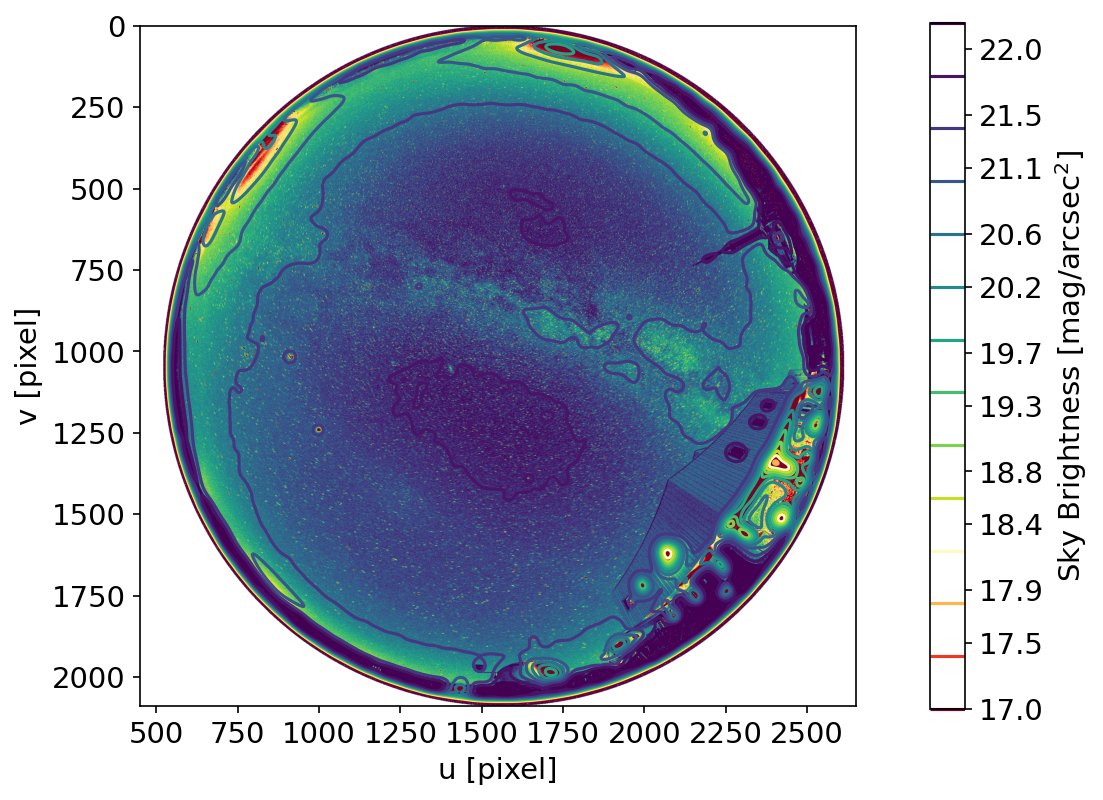

In [11]:
plot_contours(NSB, NSB_filt, nixnox, min_mag=Magnitude.MODERATE, max_mag=Magnitude.SUPER_DARK,)
